In [1]:
%%bash
python --version

Python 3.10.1


In [2]:
%%bash
conda env list

# conda environments:
#
                         /home/aji/anaconda2
                         /home/aji/anaconda2/envs/coevolution
base                     /home/aji/anaconda3
bmi219p                  /home/aji/anaconda3/envs/bmi219p
minipynetp               /home/aji/anaconda3/envs/minipynetp
openpyxl                 /home/aji/anaconda3/envs/openpyxl
pynetp                   /home/aji/anaconda3/envs/pynetp
pynetp3.10.0          *  /home/aji/anaconda3/envs/pynetp3.10.0
pytorch                  /home/aji/anaconda3/envs/pytorch
sciProj                  /home/aji/anaconda3/envs/sciProj
testenv                  /home/aji/anaconda3/envs/testenv
xlrd                     /home/aji/anaconda3/envs/xlrd
                         /home/aji/yes



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from pathlib import Path
from functools import partial
from typing import Any, Callable, NewType
import graphviz
import inspect
DataFrame = NewType('DataFrame', Any)
Qstr = NewType('Qstr', str)
Astr = NewType('Astr', str)
ColName = NewType('ColName', str)
ProteinName = NewType('ProteinName', str)

In [210]:
def load_biogrid_v4_4() -> DataFrame:
    """biogrid tab3 database to pandas dataframe"""
    dpath = Path("../data/biogrid/BIOGRID-ALL-4.4.206.tab3.txt")
    biogrid_df : DataFrame = pd.read_csv(dpath, sep="\t")
    return biogrid_df

def col_map(mapf : Callable,
            df: DataFrame, 
            col : ColName,
            ) -> DataFrame:
    """Maps the entries in a dataframe according to
       the mapping function mapf. Returns the newly
       mapped dataframe"""
    
    col_it = iter(df[col])
    col_it = map(mapf, col_it)
    df[col] = list(col_it)
    return df

def drop_columns(biogrid_df: DataFrame) -> DataFrame:
    """Drops certain columns from the biogrid pandas
       dataframe"""
    to_drop = ['BioGRID ID Interactor A',
               'BioGRID ID Interactor B',
               #'Systematic Name Interactor A',
               #'Systematic Name Interactor B',
               #'Official Symbol Interactor A',
               #'Official Symbol Interactor B',
               #'Synonyms Interactor A',
               #'Synonyms Interactor B',
               'Modification',
               'Throughput',
               'Score',
               'Qualifications',
               'Tags',
               'Source Database',
               'SWISS-PROT Accessions Interactor A',
               'TREMBL Accessions Interactor A',
               'REFSEQ Accessions Interactor A',
               'SWISS-PROT Accessions Interactor B',
               'TREMBL Accessions Interactor B',
               'REFSEQ Accessions Interactor B',
               'Ontology Term IDs',
               'Ontology Term Names',
               'Ontology Term Categories',
               'Ontology Term Qualifier IDs',
               'Ontology Term Qualifier Names',
               'Ontology Term Types'
               ]
    d = biogrid_df.drop(columns=to_drop, inplace=False)
    return d

def filter_missing_entrez_interactors(d) -> DataFrame:
    """Removes missing (-) entrez interactors
       from biogrid pandas dataframe"""
    d = d[d['Entrez Gene Interactor A'] != "-"]
    d = d[d['Entrez Gene Interactor B'] != "-"]
    return d

def get_frequency(col) -> dict[str, int]:
    """Counts the occurance of each categorical
       variable in a given pandas dataframe column.
       returns a dictionary of {"category" : count}"""
    
    freq_dict = {}
    for label in col:
        if label not in freq_dict:
            freq_dict[label]=0
        else:
            freq_dict[label] += 1
    return freq_dict


def get_physical(d):
    """Built to filter the biogrid database to only
       physical interactions"""
    
    t = d['Experimental System Type'] == 'physical'
    d = d[t]
    return d


def plot_physical_experiments(d):
    d = get_physical(d)
    plot_col(d, 'Experimental System', topn=20)


def prepare_biogrid_fpipe():
    return [load_biogrid_v4_4, drop_columns, filter_missing_entrez_interactors]

def prepare_biogrid():
    """Preprocesses biogrid dataframe for downstream analysis"""
    
    d = load_biogrid_v4_4()
    d = drop_columns(d)
    d = filter_missing_entrez_interactors(d)
    
    upper = lambda i: i.upper()
    d = col_map(upper, d, 'Systematic Name Interactor A')
    d = col_map(upper, d, 'Systematic Name Interactor B')
    d = col_map(upper, d, 'Official Symbol Interactor A')
    d = col_map(upper, d, 'Official Symbol Interactor B')
    return d
    

def plot_col(d, colname, titlename=None, topn=12):
    """Plots a horizontal bar plot of the counts of each
       category in the column. 
       
       d : pandas dataframe
       colname : str, column name
       titlename : str, name to use in plot title
       topn : int, plot the categories with the top n counts"""
    
    freq_dict = get_frequency(d[colname])
    freq_dict = dict(sorted(freq_dict.items(), key= lambda x: x[1], reverse=True))

    vals = list(freq_dict.values())[0:topn]
    keys = list(freq_dict.keys())[0:topn]

    #color = np.arange(len(keys))
    plt.barh(keys, vals)
    if titlename:
        plt.title(titlename)
    #plt.legend(keys)
    plt.show()
    
def load_tip49_spec_counts_dataset() -> DataFrame:
    """Loads in the human HEK293 tip49 dataset from the 2011
       Nature Methods SAINT paper, supplement 2."""
    
    data = Path("../data")
    apms = data / "apms"
    saint = apms / "20110108_NATUREMETHODS_8_1_SAINTProbabilisticScoringOfAffinityPurification"
    tip49 = saint / "tip49_supp2.A._Interactions.csv"
    tip49 = pd.read_csv(tip49)
    tip49 = tip49.rename(columns=tip49.iloc[1])
    tip49 = tip49.iloc[2:, 1:]
    
    #print(tip49.columns[1])
    assert tip49.columns[1] == "Prey"
    return tip49

def print_baitprey_info(spec_counts_df):
    """prints some information on baits and preys
       does an assertion check
       For tip49
       Baits: 27
       Preys: 1207"""
    
    nbaits = len(set(spec_counts_df['Bait']))
    print(f'Baits: {nbaits}')

    npreys = len(set(spec_counts_df['Prey']))
    print(f'Preys: {npreys}')
    assert nbaits == 27
    assert npreys == 1207

def check_if_tip49_proteins_in_biogrid(biogrid : DataFrame, spec : DataFrame):
    """Checks the biogrid dataframe for bait and prey proteins in tip49
       so that interaction may be mapped"""
    def p(x, y) -> tuple[dict]:
        print(f'{x} {y}')
    
    sapiens = 'Homo sapiens'
    sel = biogrid['Organism Name Interactor A'] == sapiens
    biogrid = biogrid[sel]
    p('dhuman', biogrid.shape)
    sel = biogrid['Organism Name Interactor B'] == sapiens
    biogrid = biogrid[sel]
    p('dhuman', biogrid.shape)
    off_sym_int_a_col = set(biogrid['Official Symbol Interactor A'])
    off_sym_int_b_col = set(biogrid['Official Symbol Interactor B'])
    sys_name_int_a_col = set(biogrid['Systematic Name Interactor A'])
    sys_name_int_b_col = set(biogrid['Systematic Name Interactor B'])
    
    baits = set(spec['Bait'])
    preys = set(spec['Prey'])

    
    def search_biogrid(query: set[ProteinName], 
                       db : DataFrame
                       ) -> dict[ProteinName, list[ColName]]:
        
        """searchs the following biogrid columns for the bait
           or prey protein.
           
           Official Symbol Interactor A
           Official Symbol Interactor B
           Systematic Name Interactor A
           Systematic Name Interactor B
           
           TODO: Parse and search the synonyms column"""
        
        query_dict = {}
        
        query_len = len(query)
        for i, q in enumerate(query):
            print(f'{i}/{query_len} searching {q}')
            ql = []
            if q in off_sym_int_a_col:
                ql.append('Official Symbol Interactor A')
            if q in off_sym_int_b_col:
                ql.append('Official Symbol Interactor B')
            if q in sys_name_int_a_col:
                ql.append('Systematic Name Interactor A')
            if q in sys_name_int_b_col:
                ql.append('Systematic Name Interactor B')
            
            query_dict[q] = ql
        return query_dict
    
    baits_found : dict = search_biogrid(baits, biogrid)
    preys_found : dict = search_biogrid(preys, biogrid)
    return baits_found, preys_found

def check_baits():
    syn_iter = iter(biogrid[['Synonyms Interactor A', 
                             'Synonyms Interactor B'
                            ]
                           ]
                    .values)
    syn_iter = map(lambda i: (i[0].split("|"), i[1].split("|")), syn_iter)
    bait = 'MEK4'
            
    def f(t : tuple[list[ProteinName]],
        bait : ProteinName) -> tuple[bool]:
                b1 = bait in t[0]
                b2 = bait in t[1]
                return b1, b2
            
            f = partial(f, bait = bait)
            syn_iter = map(f, syn_iter)

def is_protein_name_in_biogrid(query_dict : dict[ProteinName, list[ColName]]):
    """Checks if a protein name was found in biogrid
       
       query_dict : {[protein_name : [column_name]}
       
       The colnames represent the columns that the protein_name is in"""
    
    found_dict = {}
    for i, (key, val) in enumerate(query_dict.items()):
        found = True if len(val) > 0 else False
        found_dict[key] = found
    return found_dict

def is_protein_name_not_in_biogrid(query_dict) -> list[ProteinName]:
    """Checks if a protein name was not found in biogrid dataframe
       returns a list of all proteins not found in biogrid
       
       The query dict is the ouptput of the function
       `check_if_tip49_proteins_in_biogrid`"""
    lost_proteins = []
    for i, (pname, col_list) in enumerate(query_dict.items()):
        if len(col_list) == 0:
            lost_proteins.append(pname)
    return lost_proteins
        

def fraction_found(found : dict[ProteinName, bool]) -> tuple[float, int]:
    """Calculates the fraction fractions of baits or preys
       that were found in biogrid database.
       
       found : output of is_protein_name_in_biogrid
       returns frac, nkeys
       
       frac : float = nfound / nkeys
       nkeys : number of baits or preys"""
    
    nkeys = 0
    nfound = 0
    for i, (key, val) in enumerate(found.items()):
        nkeys+=1
        if val:
            nfound +=1
    return nfound / nkeys , nkeys

def pipe_to_gvis(fpipe : list[Callable]):
    """Returns a graphviz.Digraph object representing
       a linear functional pipe.
       
       fpipe : an ordered list of pure functions
       
       returns control_flow
       
       control_flow : graphviz.Digraph object
       where graphviz is python-graphviz
       """
    
    control_flow = graphviz.Digraph()
    for i, func in enumerate(fpipe):
        name = str(i)
        label = func.__name__
        control_flow.node(name, label)
    
    for i in range(len(fpipe) - 1):
        anno = fpipe[i].__annotations__
        r_t_str = str(anno['return'])
        control_flow.edge(str(i), str(i + 1), label=r_t_str)
    
    return control_flow

def find_idmapping_overlap(biogrid, spec_counts_df):
    """Wrapper functions that finds the overlap amongs bait and prey
       names in the tip49 dataframe and the biogrid dataframe"""
    
    baits_found, preys_found = check_if_tip49_proteins_in_biogrid(biogrid, spec_counts_df)
    baits_found = is_protein_name_in_biogrid(baits_found)
    preys_found = is_protein_name_in_biogrid(preys_found)
    baits_per, baits_n = fraction_found(baits_found)
    preys_per, preys_n = fraction_found(preys_found)

    print(f'% baits found {baits_per} of {baits_n}')
    print(f'% preys found {preys_per} of {preys_n}')
    
def assert_valid_pure_functional_pipe(fpipe):
    """Pure functions do not modify the global state of the
       program, the only operate on their inputs and return outputs.
       
       This function checks that the return type signature
       in the previous function matches the paramter signature in the
       current function
       
       fpipe is a list of pure functions to be sequentially applied
       as in f | g | h | i | j |k where f, g, h, i, j, and k are pure
       functions.
       
       Not yet working"""
    
    

    def get_params_and_return(functotest):
            annotations = functotest.__annotations__
            r_t = annotations.pop('return')
            p_t = annotations
            return p_t, r_t
    
    
    p_t, r_t = get_params_and_return(fpipe[0])
    for i in range(1, len(fpipe)):
        curr_p_t, curr_r_t = get_params_and_return(fpipe[i])
        
        try:
            assert curr_p_t == r_t
        except AssertionError:
            print(fpipe[i].__name__, curr_p_t, r_t)
        
        p_t = curr_p_t
        r_t = curr_r_t

def map_tip49_ids_to_entrez(tip49 : DataFrame) -> DataFrame:
    
    pass

In [5]:
biogrid = prepare_biogrid()

/tmp/ipykernel_173447/1073753908.py:78: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  d = load_biogrid_v4_4()


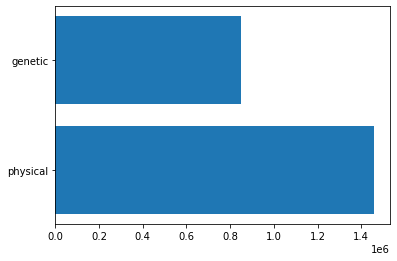

In [6]:
plot_col(biogrid,'Experimental System Type' )

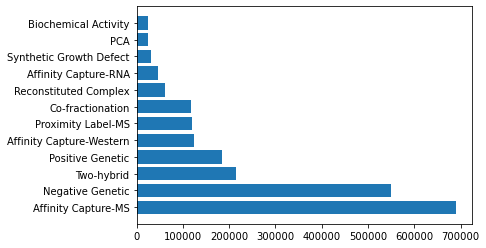

In [7]:
plot_col(biogrid, 'Experimental System', topn=12)

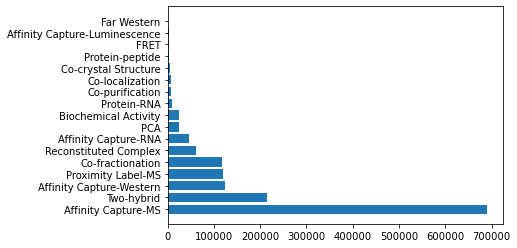

In [8]:
plot_physical_experiments(biogrid)

In [9]:
spec_counts_df = load_tip49_spec_counts_dataset()

In [10]:
find_idmapping_overlap(biogrid, spec_counts_df)

dhuman (923629, 17)
dhuman (913180, 17)
0/27 searching ACTR5
1/27 searching TFPT
2/27 searching WDR92
3/27 searching LIN9
4/27 searching INO80E
5/27 searching RP11-529I10.4
6/27 searching INO80D
7/27 searching H2AFZ
8/27 searching RUVBL2
9/27 searching TP53
10/27 searching NUFIP1
11/27 searching POLR2E
12/27 searching PIH1D1
13/27 searching KIAA0515
14/27 searching VPS72
15/27 searching ZNHIT2
16/27 searching ACTR8
17/27 searching INO80C
18/27 searching C20orf20
19/27 searching INO80B
20/27 searching ACTR6
21/27 searching ZNHIT6
22/27 searching UXT
23/27 searching ZNHIT1
24/27 searching SRCAP
25/27 searching C12orf41
26/27 searching RUVBL1
0/1207 searching NUP214
1/1207 searching C19orf2
2/1207 searching RBM26
3/1207 searching HNRNPL
4/1207 searching PELP1
5/1207 searching FXR1
6/1207 searching IVNS1ABP
7/1207 searching MAX
8/1207 searching LUC7L
9/1207 searching MRPL12
10/1207 searching THOC5
11/1207 searching MYH14
12/1207 searching HBA2
13/1207 searching MKI67
14/1207 searching DNAJ

In [183]:


def filter_biogrid(tip49 : DataFrame, biogrid : DataFrame):
    """Filter out all biogrid entries that do not
       contain candidate proteins from the tip49 dataset"""
    
    #numpy matrix of biogrid columns
    m = biogrid[['Systematic Name Interactor A',
                'Systematic Name Interactor B',
                'Official Symbol Interactor A',
                'Official Symbol Interactor B',
                'Synonyms Interactor A',
                'Synonyms Interactor B']
              ].values
    
    tip49names = set(tip49['Bait']).union(tip49['Prey'])
    
    ilocs_to_drop = []
    for i, row in enumerate(m):
        names = list(row[0:4]) + row[4].split('|') + row[5].split('|')
        names = set(names)
        
        intersection = tip49names.intersection(names)
        if len(intersection) == 0:
            ilocs_to_drop.append(i)
        
        if i % 100000 == 0:
            print("=", end="")
        
    return ilocs_to_drop
    
    
    


def check_biogrid_synonyms(syn_column_name : ColName,
                           query : set[ProteinName],
                           biogrid):
    pass

ilocs_to_drop = filter_biogrid(spec_counts_df, biogrid)
        




In [179]:
len({1, 2, 3}.intersection({}))

0

In [184]:
len(ilocs_to_drop)

1877138

In [203]:
def col_map(df: DataFrame, 
                 col : ColName,
                 mapf : Callable) -> DataFrame:
    
    col_it = iter(df[col])
    col_it = map(mapf, col_it)
    df[col] = list(col_it)
    return df

In [205]:
spec_counts_df = col_map(spec_counts_df,
                              'Bait',
                              lambda i: i.lower())

In [206]:
spec_counts_df

,Bait,Prey,IP,Spec,ctrlCounts,SAINT,PP-NSAF,Z-score,weighted D-score
2,actr5,ACTR5,ARP5,417,0|0|0|0|0|0|0|0|0,1,0.697316352520067,4.93341427067021,7.32386764271932
3,actr5,RUVBL2,ARP5,73,6|0|1|0|0|0|0|0|0,1,0.033910239152529,-0.277434577751575,2.30143615423011
4,actr5,RUVBL1,ARP5,50,3|2|0|0|0|0|0|2|0,1,0.0188476130319074,-0.445655245594782,1.6953802173525
5,actr5,INO80C,ARP5,26,0|0|0|0|0|0|0|0|0,0.99,0.17716503039295,2.47752757446183,2.16103341761436
6,actr5,ACTR8,ARP5,32,0|0|0|0|0|0|0|0|0,1,0.0326314267664079,0.101163744000279,2.1299377904367
...,...,...,...,...,...,...,...,...,...
5518,znhit2,ZNHIT2,ZnF.HIT2,358,0|0|0|0|0|0|0|0|0,1,0.95751746168747,5.00260255351579,13.7777734271275
5519,znhit2,C20orf4,ZnF.HIT2,4,0|0|0|0|0|0|0|0|0,0.97,1,5.00370233297676,1.7133212483779
5520,znhit2,TSSC4,ZnF.HIT2,4,0|0|0|0|0|0|0|0|0,0.98,1,5.00370233297676,1.7133212483779
5521,znhit2,TTC27,ZnF.HIT2,9,0|0|0|0|0|0|0|0|0,0.99,1,5.00370233297676,2.42300214615802


In [ ]:
plot_physical_experiments(biogrid)

In [ ]:
plot_col(biogrid, 'Experimental System')

In [14]:
biogrid['Synonyms Interactor A'][0]

'JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAPKK1|SEK1|SERK1|SKK1'